In [1]:
import torch
from torch.distributions import Normal
import pandas as pd

import math
import numpy as np
import sys
sys.path.append('/kaggle/input/pyjive/pyJive')
sys.path.append('/kaggle/input/truss1/trus_bridge')
sys.path.append('../pyJive/')
sys.path = list(set(sys.path))
from utils import proputils as pu
import main
from names import GlobNames as gn
from utils import nodeset as ns
import pandas as pd
import torch
import random
from objective_utils import *
from log_plot_utils import *
import matplotlib.pyplot as plt
import cProfile
import scipy.special
import os
import time
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatter

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

0
Tesla T4


In [3]:
#Objective functions
def objective_function_1D(input_array, constraint_weight): 
    assert len(input_array) == 1, f"Input array must be one-dimensional, but got shape {input_array.shape}."
    
    y = input_array[0]
    
    return oneD_lagrange_optimization(y, constraint_weight=constraint_weight, df=df, props=props, globdat=globdat)

def objective_function_2D(input_array, constraint_weight):
    assert len(input_array) == 2, f"Input array must be two-dimensional, but got shape {input_array.shape}."
    
    y = input_array[0]
    A = input_array[1]
    
    return twoD_lagrange_optimization(y, A, df=df, props=props, globdat=globdat, constraint_weight=constraint_weight)

def objective_function_6D(input_array, constraint_weight):
    assert len(input_array) == 6, f"Input array must be six-dimensional, but got shape {input_array.shape}."
    
    y_values = input_array[:5]
    A = input_array[5]
    
    return sixD_lagrange_optimization(y_values, A, constraint_weight=constraint_weight, df=df, globdat=globdat, props=props) 

def objective_function_19D(input_array, constraint_weight):
    assert len(input_array) == 19, f"Input array must be nineteen-dimensional, but got shape {input_array.shpe}."
    
    y_values = input_array[:5]
    A_values = input_array[5:]
    
    return nineteenD_lagrange_optimization(y_values, A_values, constraint_weight, df=df, props=props, globdat=globdat)

In [4]:
class BayesianOptimizer:
    def __init__(self, dimension, bounds, kernel, hyperparams, objective_function, SEED, device=device):
        self.dimension = dimension
        self.bounds = torch.tensor(bounds, dtype=torch.float32, device=device).repeat(dimension, 1) #In form of (min, max)
        self.kernel = kernel
        self.hyperparams = hyperparams
        self.objective_function = objective_function
        self.beta = hyperparams['beta']
        self.constraint_weight = hyperparams['constraint_weight']
        self.noise = hyperparams['noise']
        self.n_suggestions = hyperparams['n_suggestions']
        self.adam_iteration = hyperparams['adam_iteration']
        self.device = device
        self.hit = 0
        self.tol = 5e-10
        self.hit_tol = 0

        random.seed(SEED)
        np.random.seed(SEED)
        torch.manual_seed(SEED)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(SEED)
            torch.cuda.manual_seed_all(SEED)

        
        self.X = None            # shape (n, d)
        self.y = None            # shape (n,)
        self.y_norm = None       # shape (n,) - normalized
        self.global_y_min = None
        self.global_y_max = None
        self.alpha = None        
        self.L = None            
        
        
        self.log_df = pd.DataFrame(columns=["Iteration", "Best_X", "Iteration_Y", "Best_Y", "Best_EI", "Sig_f", "Length", "Beta"])
        

    def initialize(self, n_initial_points):
        """Initialize with random points in the given 1D bounds, plus their objective values."""
        print(f'Initializing with {n_initial_points} initial points')

        original_stdout = sys.stdout
        sys.stdout = open('/dev/null', 'w')
        
        self.X = torch.rand((n_initial_points, dimension), device=self.device, dtype=torch.float32)
        self.X = self.X * (self.bounds[0, 1] - self.bounds[0, 0]) + self.bounds[0, 0]


        self.y = torch.tensor(
            [self.objective_function(x.cpu().numpy(), self.constraint_weight) for x in self.X],
            device=self.device, dtype=torch.float32
        )
        
        sys.stdout.close()
        sys.stdout = original_stdout

        self.global_y_min = self.y.min().item()
        self.global_y_max = self.y.max().item()

        self.y_norm = (self.y - self.global_y_min) / (self.global_y_max - self.global_y_min + 1e-12)

    def update_hyperparameters(self):
        """Optimize hyperparameters `sig_f` and `length` periodically."""
        hyperparam_values = torch.tensor([
            self.hyperparams['sig_f'],
            self.hyperparams['length']
        ], requires_grad=True, device=self.device)
    
        optimizer = torch.optim.Adam([hyperparam_values], lr=0.01)
    
        for _ in range(20): 
            optimizer.zero_grad()

            hyperparam_values.data = torch.clamp(hyperparam_values, min=1e-3, max=10.0) #Added for 2D error
    
            noise = self.hyperparams['noise']
            k11 = self.kernel(self.X, self.X, {
                'sig_f': hyperparam_values[0],
                'length': hyperparam_values[1]
            })
            k11 += (noise**2 + 1e-5) * torch.eye(self.X.size(0), device=self.device, dtype=torch.float32)
    
            L = torch.linalg.cholesky(k11)
            alpha = torch.cholesky_solve(self.y_norm.unsqueeze(-1), L)
    
            log_marginal_likelihood = -0.5 * (self.y_norm.unsqueeze(-1).T @ alpha).squeeze()
            log_marginal_likelihood -= torch.sum(torch.log(torch.diag(L)))
            log_marginal_likelihood -= 0.5 * self.X.size(0) * torch.log(torch.tensor(2 * torch.pi, device=self.device))
    
            loss = -log_marginal_likelihood
            loss.backward()
            optimizer.step()
    
        self.hyperparams['sig_f'] = hyperparam_values[0].item()
        self.hyperparams['length'] = hyperparam_values[1].item()


    def update_normalization(self):
        """Recompute global_y_min, global_y_max, and y_norm after each new observation."""
        self.global_y_min = float(self.y.min().item())
        self.global_y_max = float(self.y.max().item())
        denom = (self.global_y_max - self.global_y_min) + 1e-12
        self.y_norm = (self.y - self.global_y_min) / denom

    def compute_posterior(self, X_hat):
        """
        Compute posterior *in normalized y-space*.
        Returns mu_norm, cov_norm (both are in normalized scale).
        """
        
        X_hat = X_hat.to(self.device)
        k12 = self.kernel(self.X, X_hat, self.hyperparams).float()
        k22 = self.kernel(X_hat, X_hat, self.hyperparams).float()

        mu_norm = (k12.T @ self.alpha).squeeze(-1)
        v = torch.cholesky_solve(k12, self.L)
        cov_norm = k22 - k12.T @ v

        return mu_norm, cov_norm
    
    def cholesky(self):
        """
        Cholesky decomposition based on X. Returns alpha
        """
        jitter = 1e-6
        
        k11 = self.kernel(self.X, self.X, self.hyperparams).float() 
        k11 += (self.noise**2 + jitter) * torch.eye(self.X.size(0), device=self.device, dtype=torch.float32)
        
        L = torch.linalg.cholesky(k11)
        alpha = torch.cholesky_solve(self.y_norm.unsqueeze(-1), L)
        
        return alpha, L
        

    def expected_improvement(self, X_hat):
        """
        EI in normalized scale:
         - If we are "minimizing" the raw objective, we consider the best (lowest) y_norm so far.
         - The formula uses y_min_norm, mu_norm, sigma_norm, etc.
        """
        
        X_hat = X_hat.to(self.device)
        mu_norm, cov_norm = self.compute_posterior(X_hat)
        sigma_norm = torch.sqrt(torch.clamp(torch.diag(cov_norm), min=1e-12))

        # y_norm_min = best (lowest) point in normalized scale
        y_norm_min = self.y_norm.min().item()

        normal = Normal(0, 1)

        u = (y_norm_min - mu_norm) / (sigma_norm * self.beta + 1e-12)

        u = torch.where(torch.isnan(u), torch.tensor(0.0, device=self.device), u)
        u = torch.clamp(u, min=-10.0, max=10.0)

        EI = (sigma_norm * self.beta) * (u * normal.cdf(u) + normal.log_prob(u).exp())
        return EI

    def suggest_next_point(self):
        """
        Randomly initialize candidate points, then do local gradient-based
        optimization (minimize -EI) to find maxima of EI in normalized scale.
        """
        X_candidates = torch.rand((self.n_suggestions, self.dimension), device=self.device)
        X_candidates = self.bounds[:, 0] + X_candidates * (self.bounds[:, 1] - self.bounds[:, 0])
        
        best_EI = float('-inf')
        x_proposed = None

        for x_i in X_candidates:
            x_i = x_i.unsqueeze(0).clone().detach().requires_grad_(True)
            optimizer = torch.optim.Adam([x_i], lr=0.01) #learningrate can be changed?

            for _ in range(self.adam_iteration):
                optimizer.zero_grad()
                # Minimize negative EI => maximize EI
                neg_ei = -self.expected_improvement(x_i)
                neg_ei.backward()
                optimizer.step()

                x_i.data = torch.max(x_i.data, self.bounds[:, 0])
                x_i.data = torch.min(x_i.data, self.bounds[:, 1])

                current_EI = -neg_ei.item()

                if abs(current_EI - best_EI) < (self.tol * self.beta):

                    if _ == 0:
                        self.hit_tol += 1
                        if self.hit_tol == 5:
                            self.tol = self.tol * 0.1
                            # print(f"tol lowered: {self.tol}")
                            self.hit_tol = 0
                    else:
                        self.hit_tol = 0

                    break

            with torch.no_grad():
                current_EI = self.expected_improvement(x_i).item()
                if current_EI > best_EI:
                    best_EI = current_EI
                    x_proposed = x_i.detach()

        if x_proposed is not None:
            x_proposed = x_proposed.reshape(1, -1)

        return x_proposed, best_EI

    def observe_new_points(self, X_new, y_new):
        """
        Add the newly observed point(s) to self.X and self.y, then re-normalize.
        """
        
        X_new = X_new.to(self.device)
        y_new = y_new.to(self.device)
        
        self.X = torch.cat((self.X, X_new), dim=0)
        self.y = torch.cat((self.y, y_new), dim=0)

        self.update_normalization()

    
    def optimize(self, n_iterations, depth=1e-24, update=False, plot=False):
        """
        Main optimization loop. Plots the GP posterior and EI each iteration for 1D and 2D if True. Updates hyperparameters if true.
        """
        
        start_time = time.time()
        y_min = 1e8

        if self.dimension == 1 and plot:
            output_folder = "plot_1D"
            os.makedirs(output_folder, exist_ok=True)
            x_candidates = torch.linspace(self.bounds[0, 0], self.bounds[0, 1], 100, dtype=torch.float32).unsqueeze(1).to(self.device)
            plt.figure(figsize=(12, 4 * n_iterations))
        
        elif self.dimension == 2 and plot:
            output_folder_2 = "plot_2D"
            os.makedirs(output_folder_2, exist_ok=True)
            x1_candidates = torch.linspace(self.bounds[0, 0], self.bounds[0, 1], 100, dtype=torch.float32)  # Range for the first dimension
            x2_candidates = torch.linspace(self.bounds[0, 0], self.bounds[0, 1], 100, dtype=torch.float32)  # Range for the second dimension
            x_candidates = torch.cartesian_prod(x1_candidates, x2_candidates).to(self.device)

            max_rows = (n_iterations + 9) // 10
            fig, axes = plt.subplots(max_rows, 2, figsize=(12, 4 * max_rows), squeeze=False)
            row_index = 0

        self.alpha, self.L = self.cholesky()

        for i in range(1, n_iterations + 1):
            if i % 50 == 0:
                print(f'Iteration {i}')
                
            if self.dimension == 1:
                depth = 1e-4 
            elif self.dimension == 2:
                depth = 1e-15
            elif self.dimension in [6, 19]:
                depth = 1e-30

            if i % 20 == 0 and self.dimension in [1, 2]:
                self.beta = self.beta * 0.75   
            elif i % 50 == 0 and i > 500 and self.dimension in [6, 19]:
                self.beta = self.beta * 0.75
                
            #Updating hyperparameters wrt number of iteration and dimension
            if update:
                if self.dimension == 1 and i % 5 == 0:
                    self.update_hyperparameters()

                if self.dimension in [2, 6, 19] and (i % 10 == 0):
                    if self.dimension == 2 and (i < 100):
                        self.update_hyperparameters()
                    elif self.dimension in [6, 19] and (i < 150):
                        self.update_hyperparameters()

                if self.dimension == 2 and (i > 100) and (i % 50 == 0):
                    self.update_hyperparameters()

                if self.dimension in [6, 19] and (i > 150) and (i < 500) and (i % 50 == 0):
                    self.update_hyperparameters()

            x_new, best_ei = self.suggest_next_point()
            
            # Suppress printing pyjive output
            original_stdout = sys.stdout
            sys.stdout = open(os.devnull, 'w')

            y_new_val = self.objective_function(x_new.cpu().numpy().flatten(), self.constraint_weight)
            y_new = torch.tensor([y_new_val], device=self.device, dtype=torch.float32)

            sys.stdout.close()
            sys.stdout = original_stdout

            self.observe_new_points(x_new, y_new)
            self.alpha, self.L = self.cholesky()

            #Saving values to a log
            if y_new_val < y_min:
                y_min = y_new_val
            
            #When to stop iterating
            if best_ei < depth * self.beta:
                self.hit += 1
                if self.hit >= 5:
                    print(f"Best EI: {best_ei} Hit")
                    break
            else:
                self.hit = 0
            
            self.log_df = pd.concat([
                self.log_df,
                pd.DataFrame({
                    "Iteration": [i],
                    "Best_X": [x_new.cpu().numpy().flatten().tolist()],
                    "Iteration_Y": [y_new_val],
                    "Best_Y": [y_min],
                    "Best_EI": [best_ei],
                    "Sig_f": self.hyperparams['sig_f'],
                    "Length": self.hyperparams['length'],
                    "Beta": self.beta
                })
            ], ignore_index=True)
            
            #Plotting design variables
            TITLE_FONT_SIZE = 20
            AXIS_LABEL_FONT_SIZE = 18
            TICK_FONT_SIZE = 14
            LINE_WIDTH = 3
            FIGURE_SIZE = (12, 6)
            
            if plot:
                if self.dimension == 1:
                    mu_norm, cov_norm = self.compute_posterior(x_candidates)
                    std_norm = torch.sqrt(torch.diag(cov_norm))

                    y_range = (self.global_y_max - self.global_y_min) + 1e-12
                    mu_rescaled = mu_norm * y_range + self.global_y_min
                    std_rescaled = std_norm * y_range

                    ei_vals = self.expected_improvement(x_candidates).cpu().numpy()
                    ei_vals_transformed = np.maximum(ei_vals, 1e-6)

                    # LEFT: GP Posterior
                    plt.figure(figsize=FIGURE_SIZE)
                    plt.subplot(1, 2, 1)
                    plt.title(f"Iteration {i} - GP Posterior", fontsize=TITLE_FONT_SIZE)
                    plt.plot(x_candidates.cpu().numpy(), mu_rescaled.cpu().numpy(),
                             'b-', label="GP Mean", linewidth=LINE_WIDTH)
                    plt.fill_between(
                        x_candidates.cpu().numpy().flatten(),
                        (mu_rescaled - 1.96 * std_rescaled).cpu().numpy(),
                        (mu_rescaled + 1.96 * std_rescaled).cpu().numpy(),
                        color='blue', alpha=0.3, label="GP Confidence"
                    )
                    plt.scatter(
                        self.X.cpu().numpy().flatten(),
                        self.y.cpu().numpy(),
                        color="red", zorder=5, label="Evaluated Points"
                    )
                    plt.axvline(x_new.item(), color="gray", linestyle="--", label="Next Point", linewidth=LINE_WIDTH)
                    plt.xlabel("Height", fontsize=AXIS_LABEL_FONT_SIZE)
                    plt.ylabel("Objective output", fontsize=AXIS_LABEL_FONT_SIZE)
                    plt.ylim(0, 110000)
                    plt.xticks(fontsize=TICK_FONT_SIZE)
                    plt.yticks(fontsize=TICK_FONT_SIZE)
                    plt.legend()

                    # RIGHT: EI
                    plt.subplot(1, 2, 2)
                    plt.title(f"Iteration {i} - EI | Max: {best_ei:.4f}")
                    plt.plot(x_candidates.cpu().numpy(), ei_vals_transformed, 'orange', label="EI", linewidth=LINE_WIDTH)
                    plt.axvline(x_new.item(), color="gray", linestyle="--", label="Next Point", linewidth=LINE_WIDTH)
                    plt.xlabel("Height", fontsize=AXIS_LABEL_FONT_SIZE)
                    plt.ylabel("EI", fontsize=AXIS_LABEL_FONT_SIZE)
                    plt.ylim(1e-6, 5)
                    plt.yscale('log')
                    plt.xticks(fontsize=TICK_FONT_SIZE)
                    plt.yticks(fontsize=TICK_FONT_SIZE)
                    plt.legend()

                    plt.tight_layout()
                    file_name = os.path.join(output_folder, f"iteration_{i}.png")
                    plt.savefig(file_name, dpi=300, bbox_inches="tight")
                    plt.close()
                    print(f"Plot for iteration {i} saved as {file_name}")

                if self.dimension == 2 and i % 10 == 0:
                    mu_norm, cov_norm = self.compute_posterior(x_candidates)
                    std_norm = torch.sqrt(torch.diag(cov_norm))

                    y_range = (self.global_y_max - self.global_y_min) + 1e-12
                    mu_rescaled = mu_norm * y_range + self.global_y_min
                    std_rescaled = std_norm * y_range

                    ei_vals = self.expected_improvement(x_candidates).cpu().numpy()

                    X1, X2 = np.meshgrid(x1_candidates.cpu().numpy(), x2_candidates.cpu().numpy())
                    mu_rescaled_grid = mu_rescaled.cpu().numpy().reshape(X1.shape)
                    ei_vals_grid = ei_vals.reshape(X1.shape)
                    ei_vals_grid = np.maximum(ei_vals_grid, 1e-14)

                    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

                    # LEFT: GP Posterior (Contour Plot)
                    ax = axes[0]
                    ax.set_title(f"Iteration {i} - GP Posterior", fontsize=TITLE_FONT_SIZE)
                    contour = ax.contourf(X1, X2, mu_rescaled_grid, cmap='viridis')
                    evaluated_points = self.X.cpu().numpy()
                    ax.scatter(
                        evaluated_points[:, 1], evaluated_points[:, 0],
                        color="blue", marker='o', label="Last 10 Points" if len(evaluated_points) > 10 else "Evaluated Points"
                    )
                    if len(evaluated_points) > 10:
                        ax.scatter(
                            evaluated_points[-10:, 1], evaluated_points[-10:, 0],
                            color="yellow", marker='o', label="Last 10 Points"
                        )
                    ax.scatter(x_new[0, 1].item(), x_new[0, 0].item(), color="red", marker='X', label="Next Point", s=100)
                    ax.set_xlabel('A', fontsize=AXIS_LABEL_FONT_SIZE)
                    ax.set_ylabel('y', fontsize=AXIS_LABEL_FONT_SIZE)
                    ax.tick_params(axis='both', which='major', labelsize=TICK_FONT_SIZE)
                    colorbar = fig.colorbar(contour, ax=ax, label='Objective Function Value')
                    colorbar.ax.tick_params(labelsize=TICK_FONT_SIZE)

                    ax.legend()

                    # RIGHT: EI (Contour Plot)
                    ax = axes[1]
                    ax.set_title(f"Iteration {i} - EI | Max: {best_ei:.4f}", fontsize=TITLE_FONT_SIZE)
                    contour = ax.contourf(
                        X1, X2, ei_vals_grid, cmap='magma', norm=LogNorm(vmin=1e-14, vmax=0.1)
                    )
                    ax.scatter(
                        evaluated_points[:, 1], evaluated_points[:, 0],
                        color="blue", marker='o',alpha = 0.5, label="Last 10 Points" if len(evaluated_points) > 10 else "Evaluated Points"
                    )
                    if len(evaluated_points) > 10:
                        ax.scatter(
                            evaluated_points[-10:, 1], evaluated_points[-10:, 0],
                            color="yellow", marker='o', label="Last 10 Points"
                        )

                    ax.scatter(x_new[0, 1].item(), x_new[0, 0].item(), color="red", marker='X', label="Next Point", s=100)
                    ax.set_xlabel('A', fontsize=AXIS_LABEL_FONT_SIZE)
                    ax.set_ylabel('y', fontsize=AXIS_LABEL_FONT_SIZE)
                    ax.tick_params(axis='both', which='major', labelsize=TICK_FONT_SIZE)
                    colorbar = fig.colorbar(contour, ax=ax, label='Expected Improvement', format=LogFormatter())
                    colorbar.ax.tick_params(labelsize=TICK_FONT_SIZE)
                    ax.legend()

                    # Save plot
                    file_name = os.path.join(output_folder_2, f"iteration_{i}.png")
                    plt.tight_layout()
                    plt.savefig(file_name, dpi=300, bbox_inches="tight")
                    plt.close()
                    print(f"Plot for iteration {i} saved as {file_name}")

        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Total optimization time: {elapsed_time:.2f} seconds")




        return self.log_df

In [5]:
def squared_exponential(X1, X2, hyperparams):
    sig_f = hyperparams["sig_f"]
    length = hyperparams["length"]

    sqdist = torch.cdist(X1, X2) ** 2
    return sig_f**2 * torch.exp(-sqdist / (2 * length**2))

def matern_0_5(X1, X2, hyperparams):
    """
    Matérn kernel for ν = 0.5 (simplified form).
    Args:
        X1: First set of points, a torch.Tensor of shape [n1, d].
        X2: Second set of points, a torch.Tensor of shape [n2, d].
        hyperparams: Dictionary containing 'sig_f' and 'length'.
    Returns:
        Kernel matrix of shape [n1, n2].
    """
    sig_f = hyperparams["sig_f"]
    length = hyperparams["length"]

    dist = torch.cdist(X1, X2)

    return sig_f**2 * torch.exp(-dist / length)

def matern_kernel_nu_1_5(X1, X2, hyperparams):
    """
    Matérn kernel for ν = 1.5 (simplified form).
    Args:
        X1: First set of points, a torch.Tensor of shape [n1, d].
        X2: Second set of points, a torch.Tensor of shape [n2, d].
        hyperparams: Dictionary containing 'sig_f' and 'length'.
    Returns:
        Kernel matrix of shape [n1, n2].
    """
    sig_f = hyperparams["sig_f"]
    length = hyperparams["length"]

    dist = torch.cdist(X1, X2)
    
    sqrt_3 = torch.sqrt(torch.tensor(3.0))
    factor = sqrt_3 * dist / length
    matern = (1 + factor) * torch.exp(-factor)

    return sig_f**2 * matern

def RBF_kernel(X1, X2, hyperparams):
    """
    Computes the kernel function k(x, x') based on RBF features.
    
    Parameters:
    - X1 (torch.Tensor): Input tensor of shape (n_samples_1, n_features).
    - X2 (torch.Tensor): Input tensor of shape (n_samples_2, n_features).
    - hyperparams (dict): Dictionary containing hyperparameters:
        - 'alpha': Scaling factor for the kernel.
        - 'M': Number of basis functions.
        - 'length': Scale parameter for the Gaussian basis functions.
    
    Returns:
    - torch.Tensor: Kernel matrix of shape (n_samples_1, n_samples_2).
    """
    alpha = hyperparams['alpha']
    M = hyperparams['M']
    s = hyperparams['length']
    
    
    mu_m = torch.linspace(1, 5, M)  #adapted to input space (1,5)

    def compute_phi(X, mu_m, s):
        phi = torch.exp(-((X.unsqueeze(-1) - mu_m) ** 2) / (2 * (s ** 2)))
        return phi  

    phi_X1 = compute_phi(X1, mu_m, s)  
    phi_X2 = compute_phi(X2, mu_m, s)  

    phi_X1 = phi_X1.view(X1.size(0), -1) 
    phi_X2 = phi_X2.view(X2.size(0), -1)  

    kernel_matrix = (1 / alpha) * (phi_X1 @ phi_X2.T)  

    return kernel_matrix



In [6]:
# Only used when running in Kaggle
import shutil

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE') is not None:
    files_to_copy = [
        '/kaggle/input/truss1/trus_bridge/bridge.geom',
        '/kaggle/input/truss1/trus_bridge/bridge_frequency.pro',
        '/kaggle/input/truss1/trus_bridge/bridge_updated.geom'
    ]

    destination = '/kaggle/working'

    for file in files_to_copy:
        shutil.copy(file, destination)
    print("Files copied successfully.")
else:
    print("Not running in a Kaggle environment. No files copied.")

Files copied successfully.


In [7]:
props = pu.parse_file('bridge_frequency.pro')
globdat = main.jive(props)
df = create_element_dataframe(globdat)
# df['SurfaceArea'] = 4e-4

mass  using all doftypes by default:  dict_keys(['dx', 'dy'])


In [8]:
SEED = 42

## 1D

Initializing with 2 initial points


<ipython-input-4-00388a71f07c>:313: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.log_df = pd.concat([


Best EI: 4.388539317536241e-24 Hit
Total optimization time: 13.46 seconds
[1.6187191009521484]
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
(344.4444357805449, array([12.35610874, 33.43163929, 51.74159979]))
Plot saved as 1D_EI_plot


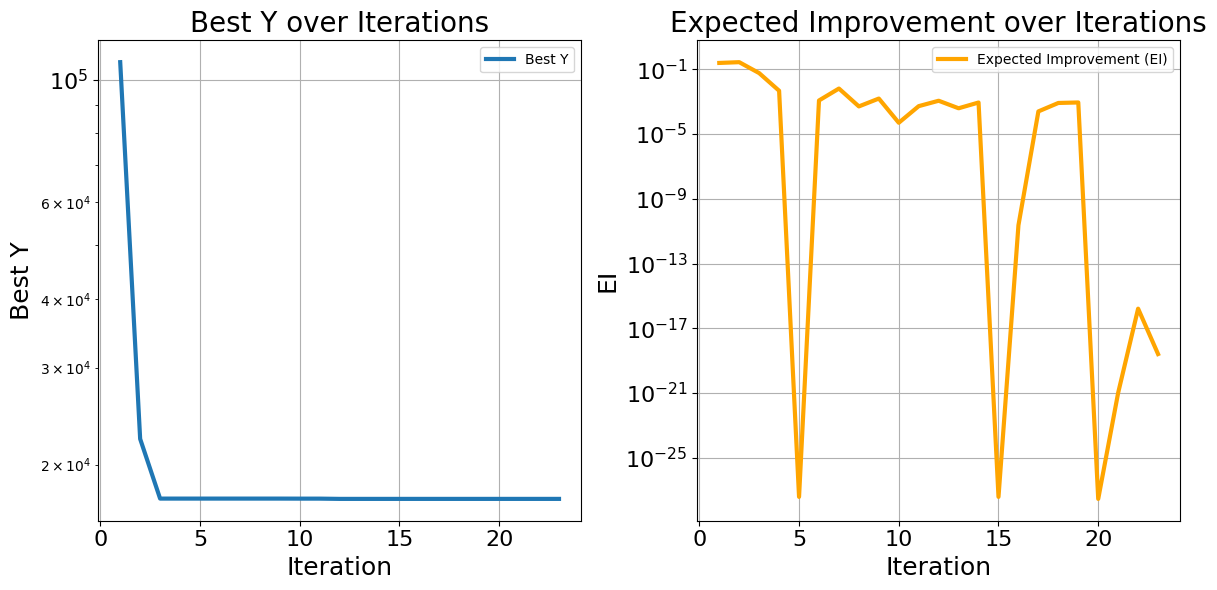

Plot saved as 1D_hyperparameter_plot


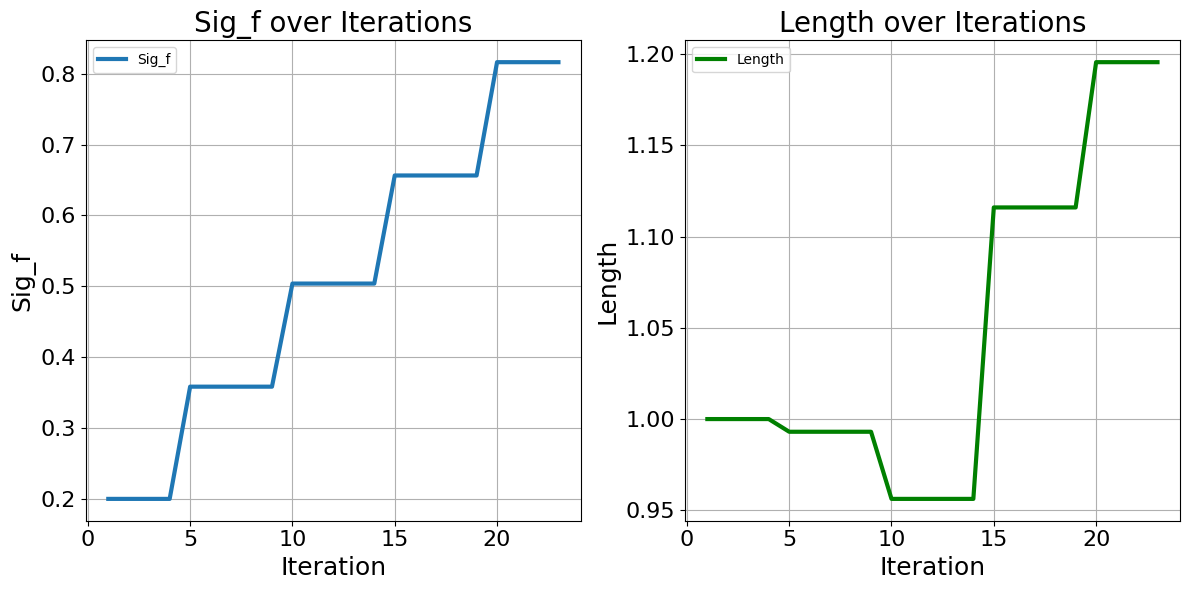

In [9]:
bounds = (1, 5)
hyperparams = {
    'sig_f': 0.2, 
    'length': 1,  
    "noise": 1e-10,
    "beta": 5.0,
    "n_suggestions": 10,
    "constraint_weight": 100,
    "adam_iteration": 20,
}


dimension = 1
optimizer = BayesianOptimizer(dimension, bounds, squared_exponential, hyperparams, objective_function_1D, SEED=42)
optimizer.initialize(n_initial_points=2)
log_df = optimizer.optimize(n_iterations=50, update=True, plot=False)

best_y_index = log_df['Best_Y'].idxmin()
best_x = log_df.loc[best_y_index, 'Best_X']
print(best_x)
print(oneD_optimization_function(best_x[0], df, geom_updated_file_path='bridge_updated.geom', props=props, globdat=globdat))

plot_optimization_logs(log_df, save=True, file_name='1D_EI_plot')
plot_parameters_over_iterations(log_df, save=True, file_name='1D_hyperparameter_plot')

## 2D

In [10]:
bounds = (1, 5)
hyperparams = {
    'sig_f': 0.2, 
    'length': 1,  #
    "noise": 1e-10,
    "beta": 5.0,
    "n_suggestions": 10,
    "constraint_weight": 500,
    "adam_iteration": 20,
}


dimension = 2
optimizer = BayesianOptimizer(dimension, bounds, squared_exponential, hyperparams, objective_function_2D, SEED=20)
optimizer.initialize(n_initial_points=10) #Deminished for examplimary purpose
log_df_2 = optimizer.optimize(n_iterations=2, update=True, plot=False) #Deminished for examplimary purpose

best_y_index = log_df_2['Best_Y'].idxmin()
best_x = log_df_2.loc[best_y_index, 'Best_X']
print(best_x)
print(twoD_optimization_function(best_x[0], best_x[1]/10000, df=df, geom_updated_file_path='bridge_updated.geom', props=props, globdat=globdat))

Initializing with 10 initial points


<ipython-input-4-00388a71f07c>:313: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.log_df = pd.concat([


Total optimization time: 1.40 seconds
[1.8566396236419678, 3.8736836910247803]
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
(450.3772226166761, array([22.69827366, 58.75696259, 88.4663267 ]))


## 6D

Initializing with 2 initial points


<ipython-input-4-00388a71f07c>:313: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.log_df = pd.concat([


Iteration 50
Total optimization time: 172.34 seconds


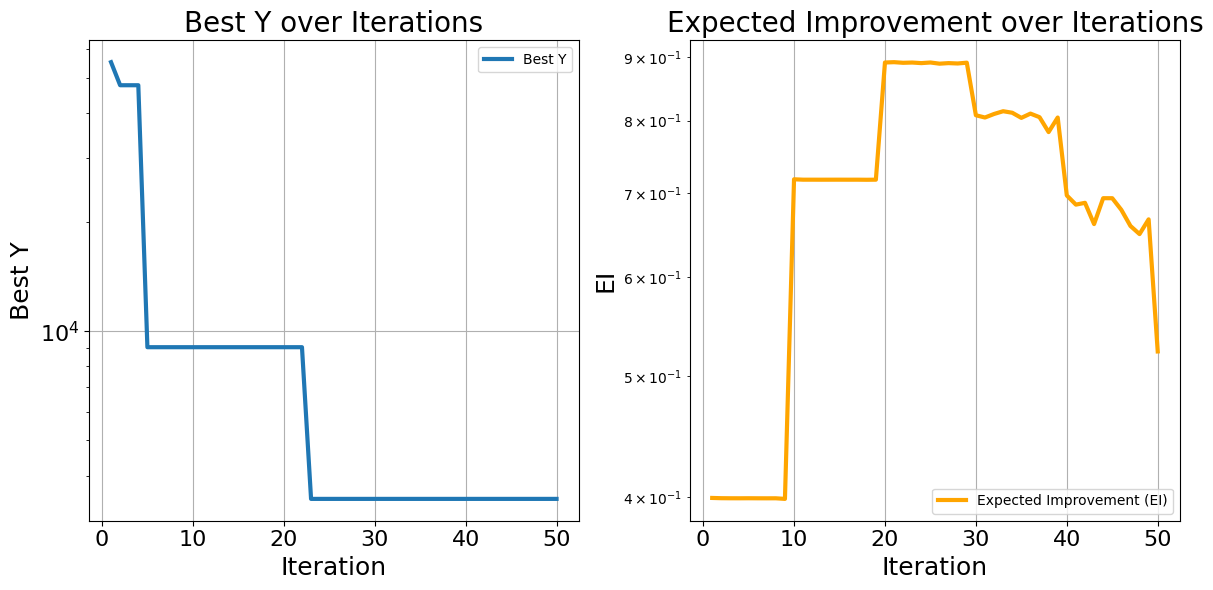

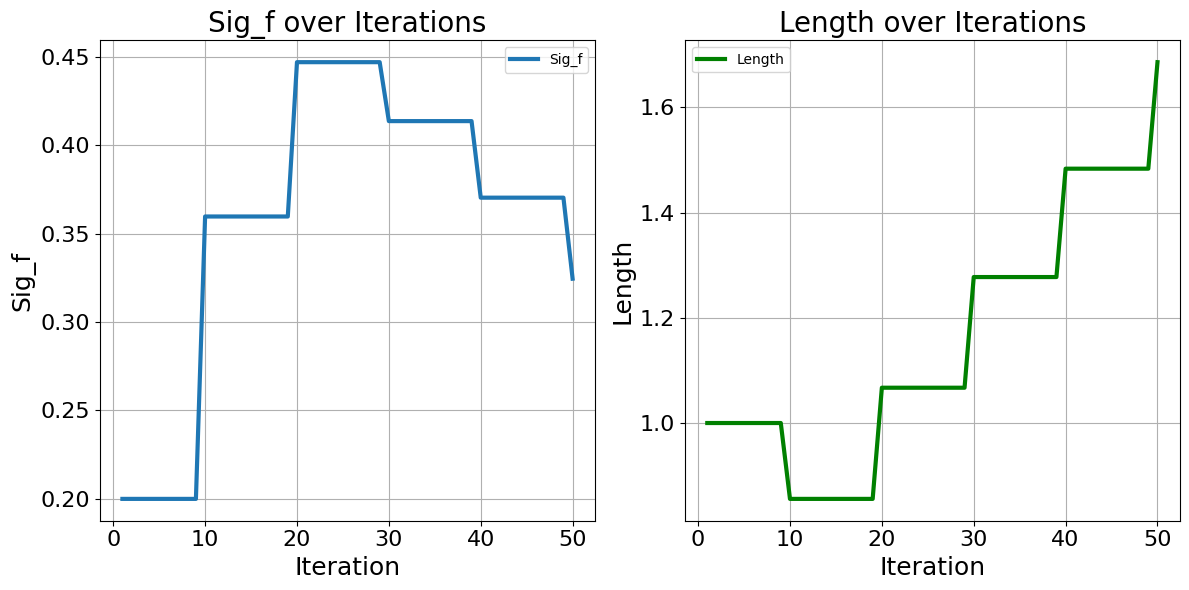

Optimized values: y_i = [2.846174955368042, 3.748116970062256, 5.0, 5.0, 4.3055853843688965] and A = 
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
(655.3887638421236, array([23.13526649, 35.38926018, 57.41079329]))


In [11]:
dimension = 6
n_iterations = 50 #Reduced to 50 for shorter running time only for example purpose of notebook
n_initial_points = 2 #Deminished for examplimary purpose

bounds = (1, 5)
hyperparams = {
    "sig_f": 0.2, 
    "length": 1, 
    "noise": 1e-8,
    "beta": 5.0,
    "second_beta": 0.5,
    "n_suggestions": 10,
    "constraint_weight": 100,
    "adam_iteration": 100
}


optimizer_6 = BayesianOptimizer(dimension, 
                                bounds, 
                                squared_exponential, 
                                hyperparams, 
                                objective_function_6D,
                                SEED=SEED)

optimizer_6.initialize(n_initial_points=n_initial_points)
log_df_6 = optimizer_6.optimize(n_iterations=n_iterations, update=True, plot=False)
#save_log_with_explanation(log_df_6,name=name, seed=SEED, dimension=dimension, n_iterations=n_iterations, n_initial_points=n_initial_points, hyperparams=hyperparams)

plot_optimization_logs(log_df_6)
plot_parameters_over_iterations(log_df_6)

best_y_index = log_df_6['Best_Y'].idxmin()
best_x = log_df_6.loc[best_y_index, 'Best_X']
y_values = best_x[:5]
A = best_x[5]
print(f'Optimized values: y_i = {y_values} and A = ')
print(sixD_optimization_function(y_values, A, df=df, geom_updated_file_path='bridge_updated.geom', props=props, globdat=globdat))

## 19D

Initializing with 2 initial points


<ipython-input-4-00388a71f07c>:313: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.log_df = pd.concat([


Iteration 50
Total optimization time: 140.09 seconds


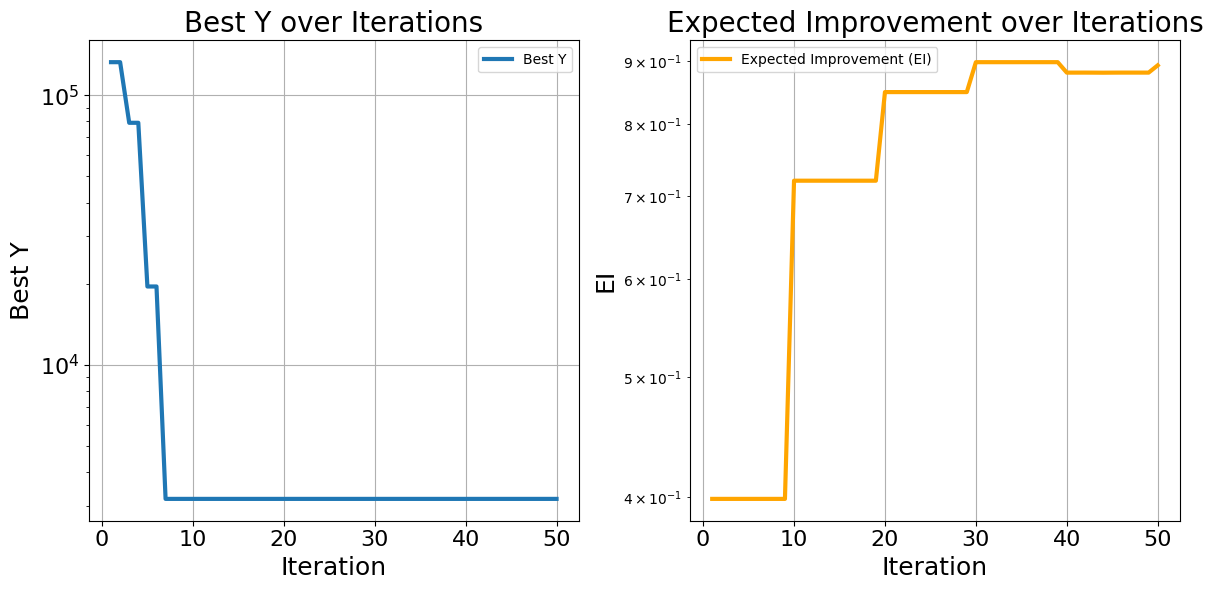

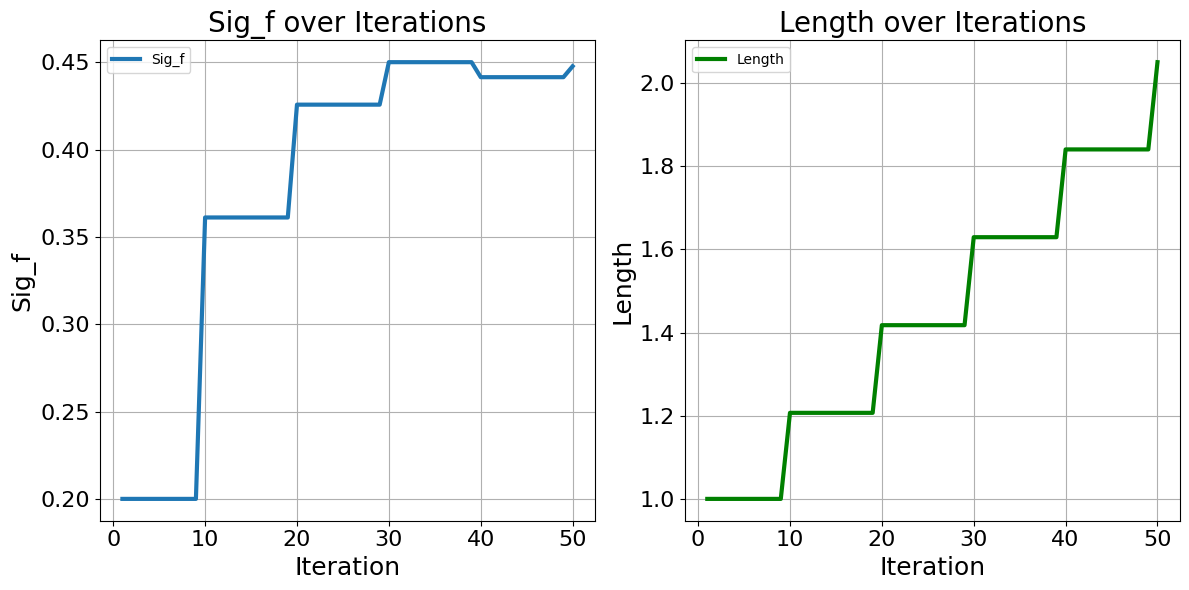

y_values= [2.4270217418670654, 2.188166856765747, 2.3169729709625244, 2.592752695083618, 3.544525384902954]
A_values= [2.6659622192382812, 1.9977456331253052, 4.214807510375977, 2.1092770099639893, 4.885161876678467, 4.016139030456543, 4.94614315032959, 4.46720552444458, 3.8747076988220215, 1.8872058391571045, 1.4143325090408325, 1.4284772872924805, 3.794590711593628, 1.3989471197128296]
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])


(449.05896079376834, array([15.63956736, 37.11167449, 74.89754461]))

In [12]:
dimension = 19
n_iterations = 50 #Reduced to 50 for shorter running time only for example purpose of notebook
n_initial_points = 2 #Deminished for examplimary purpose

bounds = (1, 5)
hyperparams = {
    "sig_f": 0.2, 
    "length": 1, 
    "noise": 1e-8,
    "beta": 5.0,
    "n_suggestions": 10,
    "constraint_weight": 100,
    "adam_iteration": 100
}

optimizer_19 = BayesianOptimizer(dimension, 
                                bounds, 
                                squared_exponential, 
                                hyperparams, 
                                objective_function_19D,
                                SEED=SEED)

optimizer_19.initialize(n_initial_points=n_initial_points)
log_df_19 = optimizer_19.optimize(n_iterations=n_iterations, update=True, plot=False)
#save_log_with_explanation(log_df_19,name=name, seed=SEED, dimension=dimension, n_iterations=n_iterations, n_initial_points=n_initial_points, hyperparams=hyperparams)

plot_optimization_logs(log_df_19, save=False, file_name='/kaggle/working/19D_EI_plot_saturday')
plot_parameters_over_iterations(log_df_19, save=False, file_name='/kaggle/working/19D_hyperparameter_plot_saturday')

best_y_index = log_df_19['Best_Y'].idxmin()
best_x = log_df_19.loc[best_y_index, 'Best_X']
y_values = best_x[:5]
A_values = best_x[5:]
print(f'y_values= {y_values}')
print(f'A_values= {A_values}')
nineteenD_optimization_function(y_values, A_values, df=df, geom_updated_file_path='bridge_updated.geom', props=props, globdat=globdat)